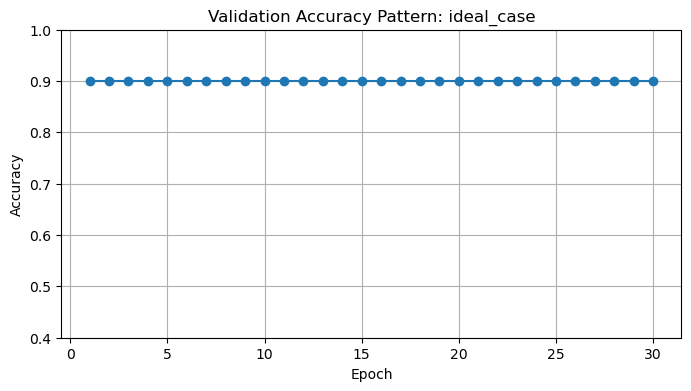

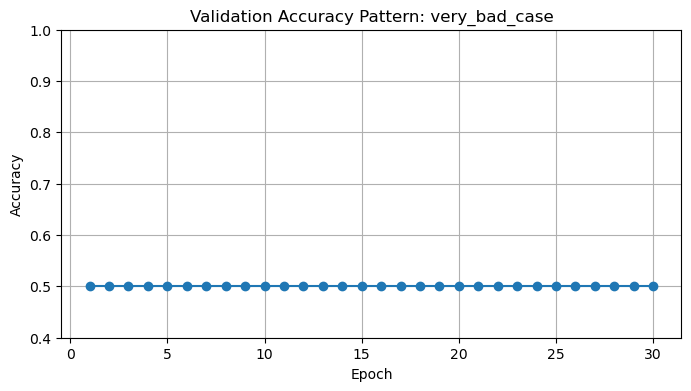

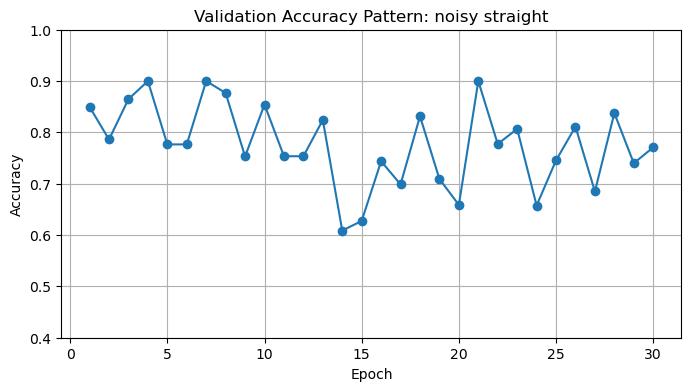

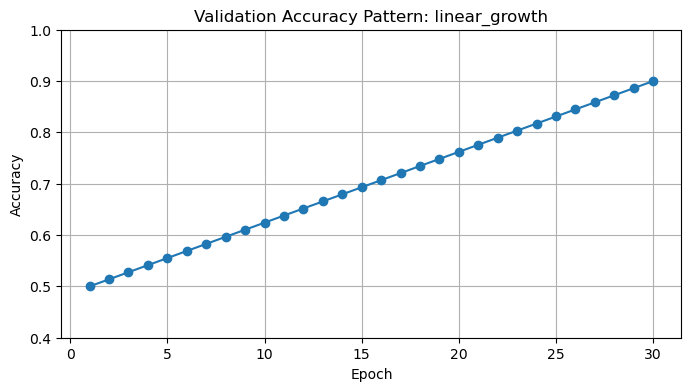

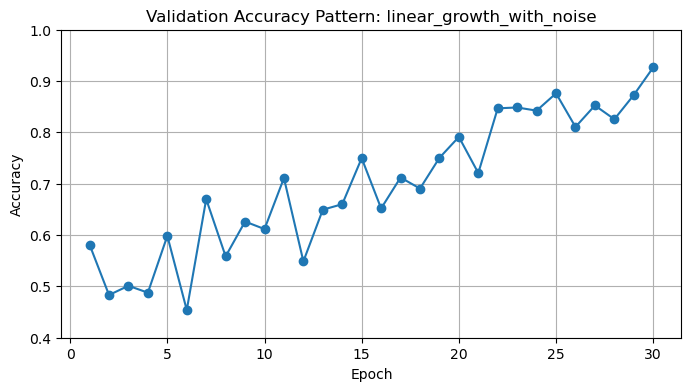

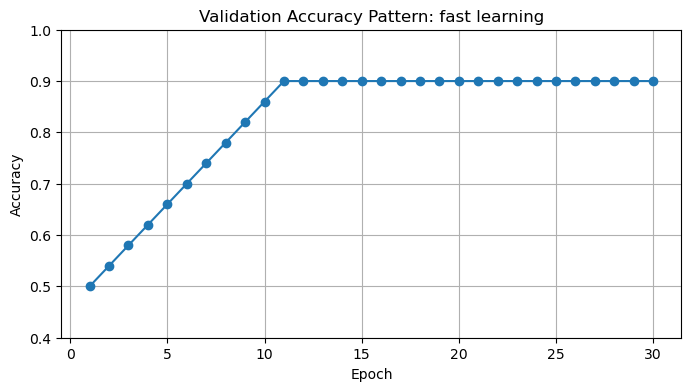

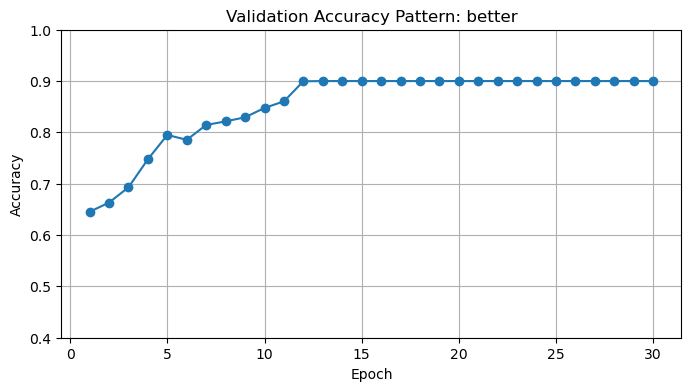

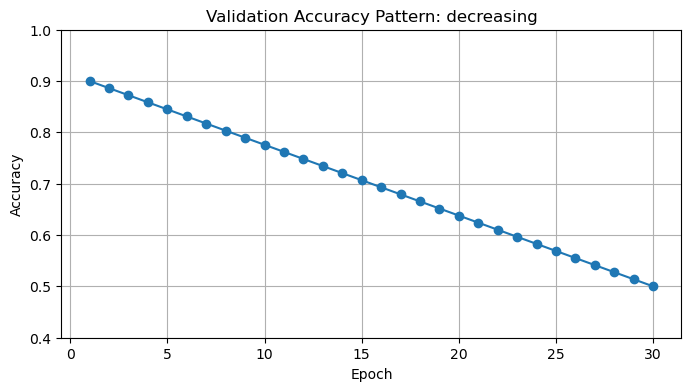

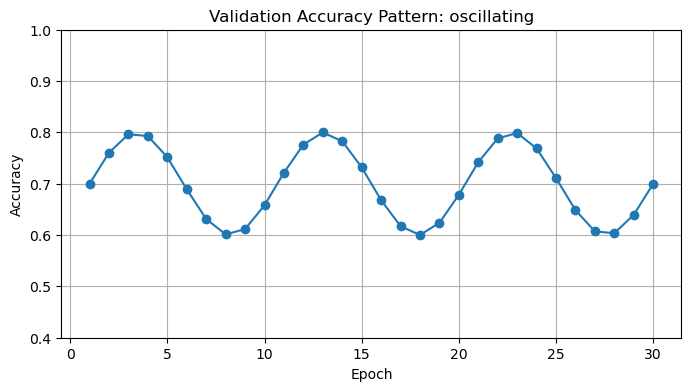

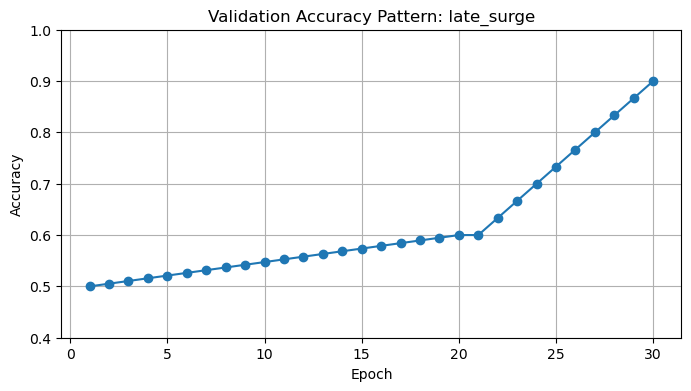

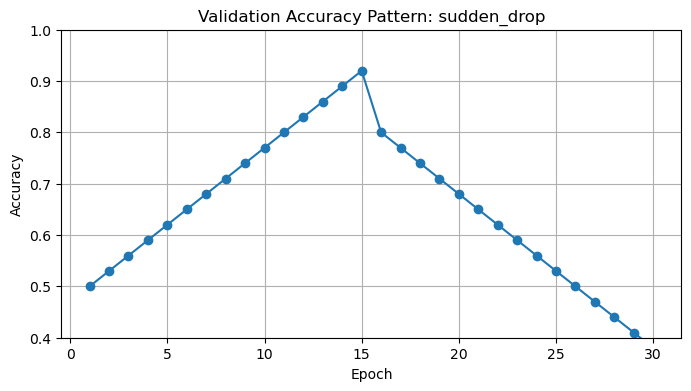

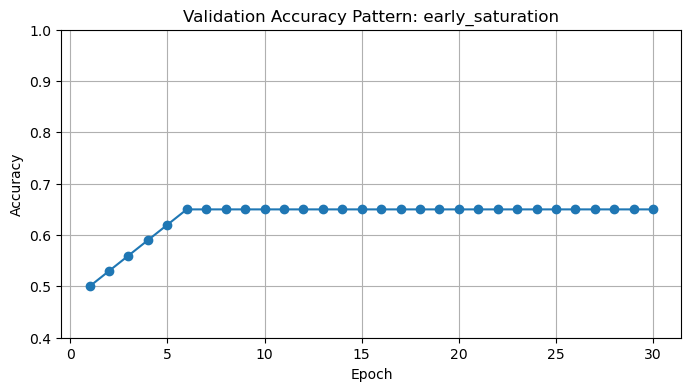

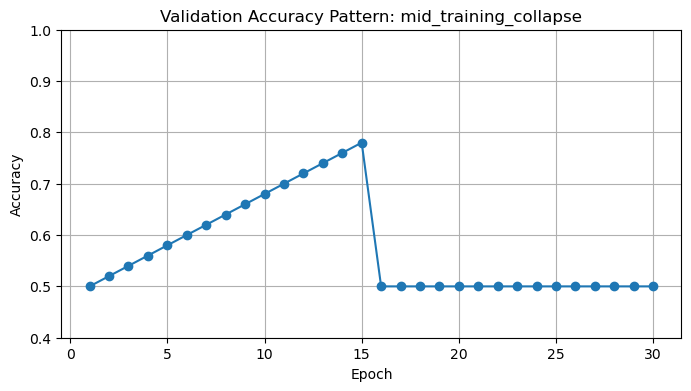

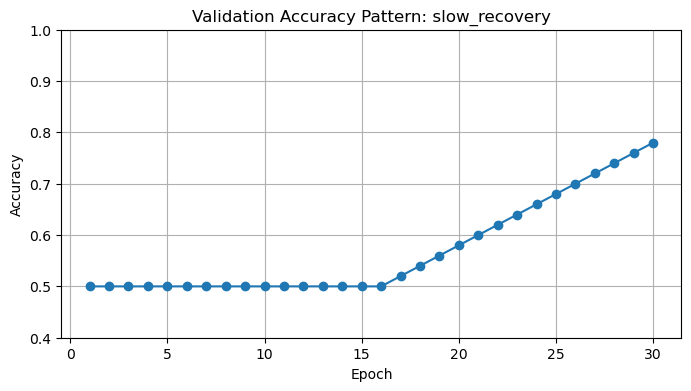

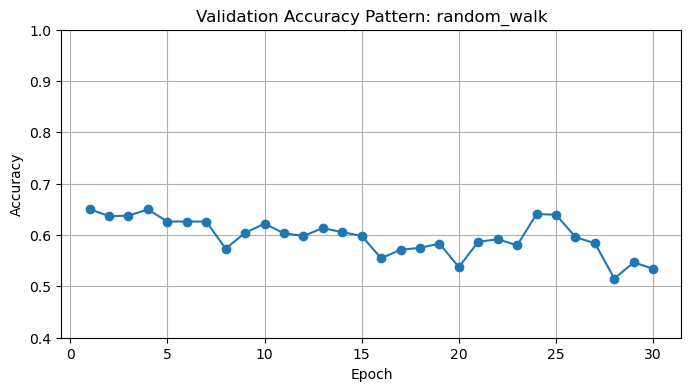

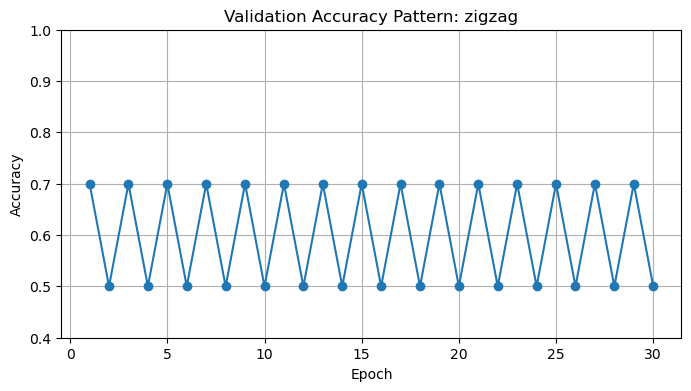

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def generate_validation_accuracy_patterns(epochs=30):
    patterns = {}

    # 1. Ideal Case
    patterns["ideal_case"] = [0.9] * epochs
    # 1.75 Very Bad Case
    patterns["very_bad_case"] = [0.5] * epochs
    # 1.9 Noisy stright
    np.random.seed(42)
    patterns["noisy straight"] = np.clip(np.random.normal(0.8, 0.1, epochs), 0.5, 0.9).tolist()

    # 2. Linear Growth
    patterns["linear_growth"] = np.linspace(0.5, 0.9, epochs).tolist()
    # 2.5 Linear Growth with Noise
    np.random.seed(1)
    patterns["linear_growth_with_noise"] = (
        np.clip(np.linspace(0.5, 0.9, epochs) + np.random.normal(0, 0.05, epochs), 0.4, 1.0)
    ).tolist()  

    # 3. fast learning
    patterns["fast learning"] = [0.5 + 0.04 * i for i in range(10)] + [0.9] * 20

    # 4. Better
    np.random.seed(0)
    patterns["better"] = (
        np.clip(np.cumsum(np.random.normal(0.01, 0.02, epochs)) + 0.6, 0.5, 0.9)
    ).tolist()

    # 5. Decreasing
    patterns["decreasing"] = np.linspace(0.9, 0.5, epochs).tolist()

    # 6. Oscillating
    patterns["oscillating"] = (
        0.7 + 0.1 * np.sin(np.linspace(0, 6 * np.pi, epochs))
    ).tolist()

    # 8. Late Surge
    late = np.concatenate([np.linspace(0.5, 0.6, 20), np.linspace(0.6, 0.9, 10)])
    patterns["late_surge"] = late.tolist()

    rise = [0.5 + 0.03*i for i in range(15)]
    drop = [0.8 - 0.03*i for i in range(15)]
    patterns["sudden_drop"] = rise + drop

    patterns["early_saturation"] = [0.5 + 0.03 * i for i in range(5)] + [0.65] * 25

    patterns["mid_training_collapse"] = [0.5 + 0.02 * i for i in range(15)] + [0.5] * 15

    patterns["slow_recovery"] = [0.5] * 15 + [0.5 + 0.02 * i for i in range(15)]

    np.random.seed(7)
    patterns["random_walk"] = np.clip(np.cumsum(np.random.normal(0, 0.03, 30)) + 0.6, 0.4, 0.95).tolist()

    patterns["zigzag"] = [0.6 + 0.1 * (-1) ** i for i in range(30)]

    return patterns


# Generate the patterns
patterns = generate_validation_accuracy_patterns()

# Plotting all patterns inline
for name, acc_list in patterns.items():
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(acc_list) + 1), acc_list, marker="o")
    plt.title(f"Validation Accuracy Pattern: {name}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim(0.4, 1.0)
    plt.grid(True)
    plt.show()

                 Pattern     SM     OP     LS  Final Score
              ideal_case 0.9000 1.0000 0.0810       0.7724
                  better 0.8506 1.0000 0.0486       0.7298
           fast learning 0.8191 1.0000 0.0540       0.7131
           linear_growth 0.6929 1.0000 0.0027       0.6168
linear_growth_with_noise 0.6883 1.0000 0.0028       0.6141
        early_saturation 0.6343 1.0000 0.0488       0.6001
          noisy straight 0.7728 0.5242 0.0729       0.5977
              late_surge 0.6104 1.0000 0.0027       0.5673
             oscillating 0.6976 0.6070 0.0432       0.5572
           slow_recovery 0.5657 1.0000 0.0023       0.5403
           very_bad_case 0.5000 1.0000 0.0450       0.5180
             random_walk 0.5964 0.5586 0.0586       0.4930
              decreasing 0.6929 0.1353 0.0810       0.4752
                  zigzag 0.5950 0.3679 0.0630       0.4558
             sudden_drop 0.6398 0.0672 0.0442       0.4150
   mid_training_collapse 0.5657 0.2466 0.0374       0.40

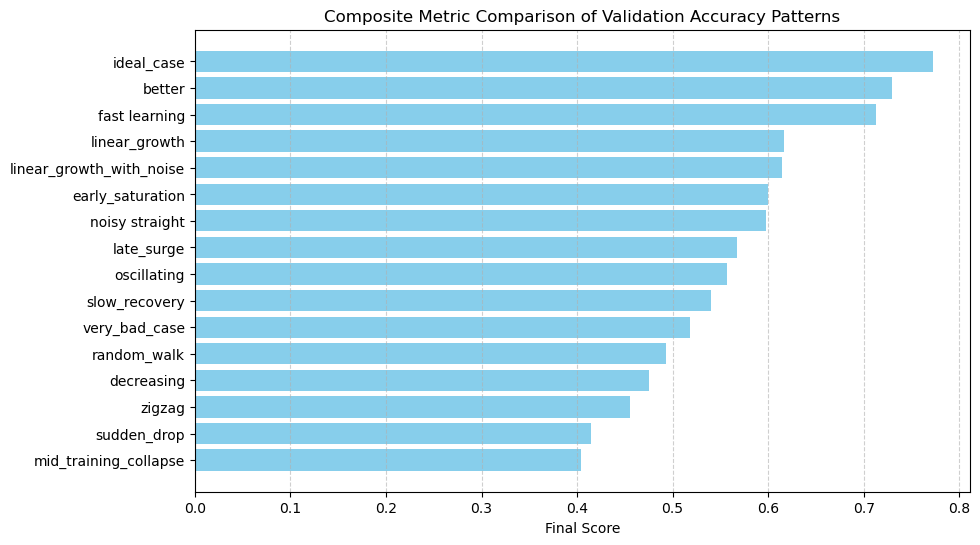

In [2]:
import pandas as pd

# --- Metric Definitions ---
def swauc(acc, lam=0.5):
    acc = np.array(acc)
    auc = np.mean(acc)
    var = np.var(acc)
    return round(auc - lam * var, 4)


def odp(acc, gamma=5):
    peak = np.max(acc)
    final = acc[-1]
    drop = peak - final
    return round(np.exp(-gamma * drop), 4)


def les(acc):
    peak = np.max(acc) * 0.09
    peak_epoch = np.argmax(acc)
    T = len(acc)
    return round(((T - peak_epoch) / T) * peak, 4)


def final_score(swauc_val, odp_val, les_val, alpha=0.6, beta=0.2, gamma=0.4):
    return round(alpha * swauc_val + beta * odp_val + gamma * les_val, 4)


# --- Run Metrics on All Patterns ---
# patterns = generate_validation_accuracy_patterns()
results = []

for name, acc in patterns.items():
    s = swauc(acc)
    o = odp(acc)
    l = les(acc)
    f = final_score(s, o, l)
    results.append({"Pattern": name, "SM": s, "OP": o, "LS": l, "Final Score": f})

df = (
    pd.DataFrame(results)
    .sort_values("Final Score", ascending=False)
    .reset_index(drop=True)
)

# --- Display Table ---
print(df.to_string(index=False))

# --- Plot Final Score Bar Chart ---
plt.figure(figsize=(10, 6))
plt.barh(df["Pattern"], df["Final Score"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Final Score")
plt.title("Composite Metric Comparison of Validation Accuracy Patterns")
plt.grid(True, axis="x", linestyle="--", alpha=0.6)
plt.show()

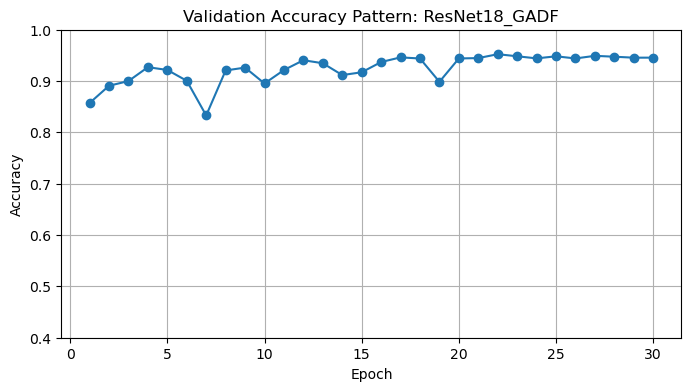

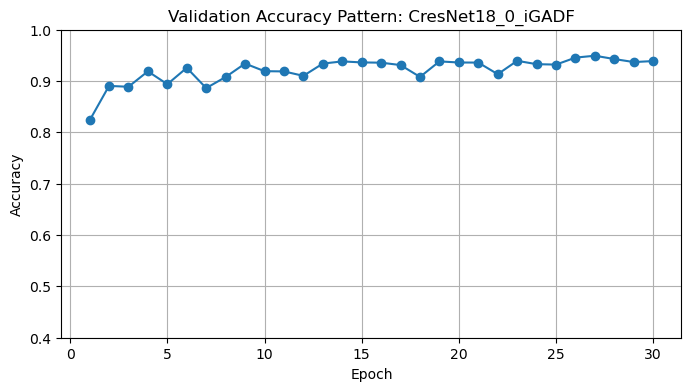

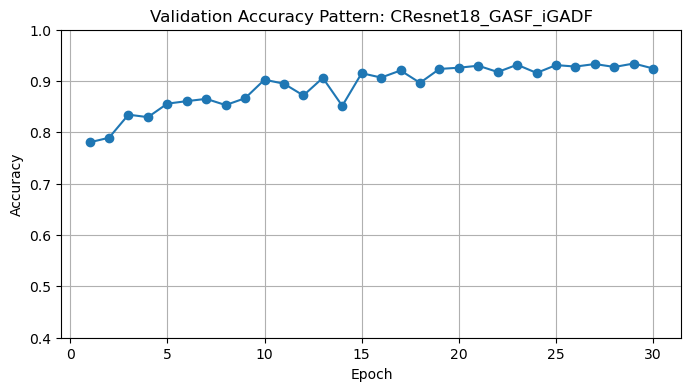

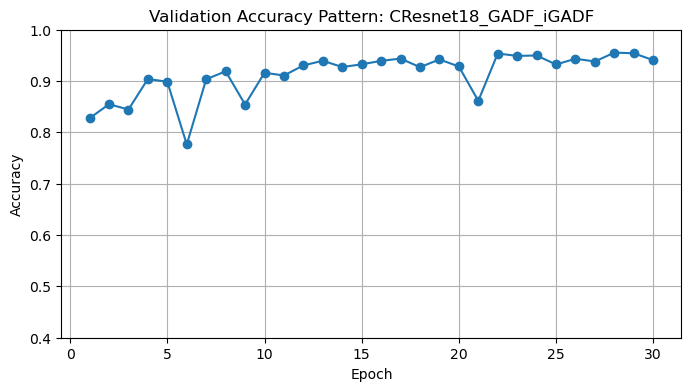

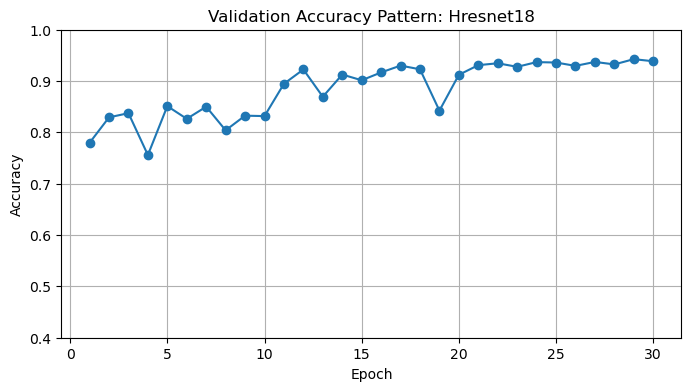

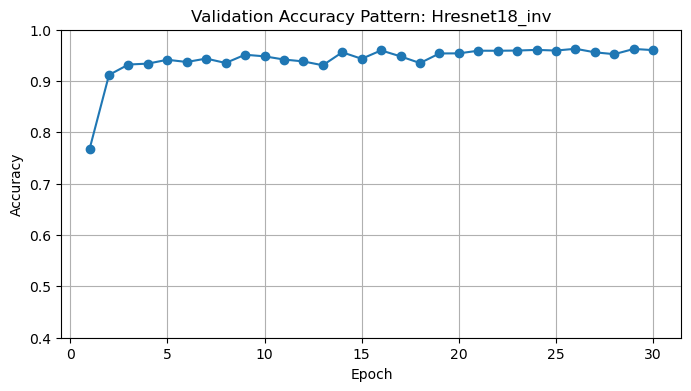

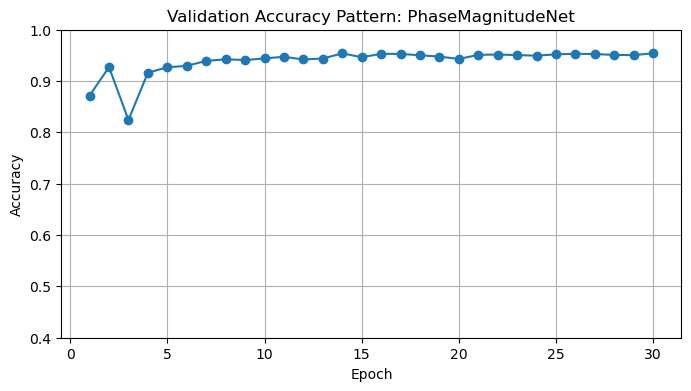

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("saved_models/validation_acc_combined.csv")
# Display the first few rows of the DataFrame
model_data = df.drop(columns=["Epochs"])

valdidation_acc = {col: model_data[col].to_numpy() for col in model_data.columns}


for name, acc_list in valdidation_acc.items():
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(acc_list) + 1), acc_list, marker="o")
    plt.title(f"Validation Accuracy Pattern: {name}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim(0.4, 1.0)
    plt.grid(True)
    plt.show()

             Pattern     SM     OP     LS  Final Score
       Hresnet18_inv 0.9413 0.9869 0.0144       0.7679
   PhaseMagnitudeNet 0.9383 1.0000 0.0029       0.7641
       ResNet18_GADF 0.9242 0.9671 0.0257       0.7582
   CresNet18_0_iGADF 0.9211 0.9492 0.0114       0.7471
CResnet18_GADF_iGADF 0.9124 0.9287 0.0086       0.7366
           Hresnet18 0.8843 0.9799 0.0057       0.7288
CResnet18_GASF_iGADF 0.8900 0.9525 0.0056       0.7267


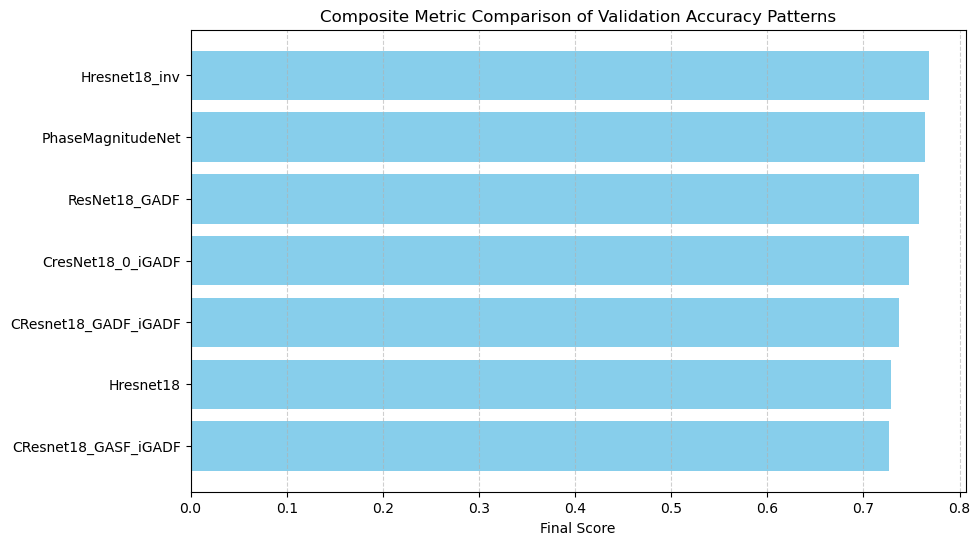

In [4]:
# --- Metric Definitions ---
def swauc(acc, lam=0.5):
    acc = np.array(acc)
    auc = np.mean(acc)
    var = np.var(acc)
    return round(auc - lam * var, 4)


def odp(acc, gamma=5):
    peak = np.max(acc)
    final = acc[-1]
    drop = peak - final
    return round(np.exp(-gamma * drop), 4)


def les(acc):
    peak = np.max(acc)*0.09
    peak_epoch = np.argmax(acc)
    T = len(acc)
    return round(((T - peak_epoch) / T) * peak, 4)


def final_score(swauc_val, odp_val, les_val, alpha=0.6, beta=0.2, gamma=0.4):
    return round(alpha * swauc_val + beta * odp_val + gamma * les_val, 4)


# --- Run Metrics on All Patterns ---
# patterns = generate_validation_accuracy_patterns()
results = []

for name, acc in valdidation_acc.items():
    s = swauc(acc)
    o = odp(acc)
    l = les(acc)
    f = final_score(s, o, l)
    results.append({"Pattern": name, "SM": s, "OP": o, "LS": l, "Final Score": f})

df = (
    pd.DataFrame(results)
    .sort_values("Final Score", ascending=False)
    .reset_index(drop=True)
)

# --- Display Table ---
print(df.to_string(index=False))

# --- Plot Final Score Bar Chart ---
plt.figure(figsize=(10, 6))
plt.barh(df["Pattern"], df["Final Score"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Final Score")
plt.title("Composite Metric Comparison of Validation Accuracy Patterns")
plt.grid(True, axis="x", linestyle="--", alpha=0.6)
plt.show()